# Model 3 LOOCV評価システム - 動作確認・デバッグ

このノートブックでは、LOOCV評価システムの動作を段階的に確認し、デバッグを行います。

In [1]:
import os
import sys
from pathlib import Path

# プロジェクトルートをPythonパスに追加
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(project_root))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from bayesian_statistics.model3_compositional_metrics import CompositionalMetrics

# 自作モジュール
from bayesian_statistics.model3_config import Model3Config, Model3Pipeline
from bayesian_statistics.model3_loocv import LOOCVConfig, LOOCVEvaluator

# 日本語フォント設定
plt.rcParams["font.family"] = "DejaVu Sans"
sns.set_style("whitegrid")

print("モジュールのインポートが完了しました")

モジュールのインポートが完了しました


## 1. 基本設定とデータ準備

In [2]:
# 基本設定
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

# 設定の作成
model_config = Model3Config(data_dir=data_dir)
loocv_config = LOOCVConfig(
    n_trials=5,  # デバッグ用に少なく設定
    verbose=True,
    random_seed=42,
)

print(f"データディレクトリ: {data_dir}")
print("モデル設定:")
print(f"  - NW sigma: {model_config.nw_sigma}")
print(f"  - NW sigma_for_sites: {model_config.nw_sigma_for_sites}")
print(f"  - 時期: {model_config.time_periods}")
print(f"  - 産地: {model_config.origins}")
print("LOOCV設定:")
print(f"  - 試行回数: {loocv_config.n_trials}")
print(f"  - Zero置換値: {loocv_config.zero_replacement}")

データディレクトリ: /home/ohta/dev/bayesian_statistics/data/
モデル設定:
  - NW sigma: 500
  - NW sigma_for_sites: 0.1
  - 時期: {0: '早期・早々期', 1: '前期', 2: '中期', 3: '後期', 4: '晩期'}
  - 産地: ['神津島', '信州', '箱根', '高原山', 'その他']
LOOCV設定:
  - 試行回数: 5
  - Zero置換値: 1e-06


In [3]:
# パイプラインの作成と前処理の実行
print("=== 前処理を実行中 ===")
pipeline = Model3Pipeline(model_config)
preprocessor = pipeline.run_preprocessing()

print("\n前処理完了:")
print(f"  - 標高データ: {preprocessor.df_elevation.shape}")
print(f"  - 黒曜石データ: {preprocessor.df_obsidian.shape}")
print(f"  - 遺跡データ: {preprocessor.df_sites.shape}")

=== 前処理を実行中 ===
=== 前処理を開始 ===
データを読み込んでいます...
標高データ: (1357520, 42)
黒曜石データ: (30070, 11)
遺跡データ: (274, 49)

前処理完了:
  - 標高データ: (1357520, 42)
  - 黒曜石データ: (30070, 11)
  - 遺跡データ: (274, 49)


## 2. Compositional Data評価指標のテスト

In [4]:
# Compositional Metricsのテスト
metrics = CompositionalMetrics(zero_replacement=1e-6)

# テスト用のデータ
test_x = np.array([0.4, 0.3, 0.2, 0.1, 0.0])  # 神津島、信州、箱根、高原山、その他
test_y = np.array([0.3, 0.4, 0.15, 0.1, 0.05])

print("=== Compositional Data評価指標のテスト ===")
print(f"テストデータ1: {test_x} (合計: {np.sum(test_x):.3f})")
print(f"テストデータ2: {test_y} (合計: {np.sum(test_y):.3f})")

# 妥当性チェック後のデータ
validated_x = metrics._validate_composition(test_x)
validated_y = metrics._validate_composition(test_y)
print("\n妥当性チェック後:")
print(f"データ1: {validated_x} (合計: {np.sum(validated_x):.3f})")
print(f"データ2: {validated_y} (合計: {np.sum(validated_y):.3f})")

# 評価指標の計算
aitchison_dist = metrics.aitchison_distance(test_x, test_y)
total_var = metrics.total_variation(test_x, test_y)

print("\n評価指標:")
print(f"  - Aitchison Distance: {aitchison_dist:.4f}")
print(f"  - Total Variation: {total_var:.4f}")

# CLR変換のテスト
clr_x = metrics.clr_transform(test_x)
clr_y = metrics.clr_transform(test_y)
print("\nCLR変換:")
print(f"  - CLR(x): {clr_x}")
print(f"  - CLR(y): {clr_y}")
print(f"  - CLR変換後のユークリッド距離: {np.sqrt(np.sum((clr_x - clr_y) ** 2)):.4f}")
print(
    f"  - Aitchison距離との一致: {np.allclose(aitchison_dist, np.sqrt(np.sum((clr_x - clr_y) ** 2)))}"
)

=== Compositional Data評価指標のテスト ===
テストデータ1: [0.4 0.3 0.2 0.1 0. ] (合計: 1.000)
テストデータ2: [0.3  0.4  0.15 0.1  0.05] (合計: 1.000)

妥当性チェック後:
データ1: [3.999996e-01 2.999997e-01 1.999998e-01 9.999990e-02 9.999990e-07] (合計: 1.000)
データ2: [0.3  0.4  0.15 0.1  0.05] (合計: 1.000)

評価指標:
  - Aitchison Distance: 9.7535
  - Total Variation: 95.1309

CLR変換:
  - CLR(x): [ 3.05326869  2.76558662  2.36012151  1.66697433 -9.84595114]
  - CLR(y): [ 0.65916737  0.94684945 -0.03397981 -0.43944492 -1.1325921 ]
  - CLR変換後のユークリッド距離: 9.7535
  - Aitchison距離との一致: True


## 3. LOOCV評価器の初期化と基本動作確認

In [5]:
# LOOCV評価器の作成
print("=== LOOCV評価器を初期化 ===")
evaluator = LOOCVEvaluator(
    preprocessor=preprocessor, model_config=model_config, loocv_config=loocv_config
)

print(f"対象遺跡数: {len(evaluator.site_ids)}")
print(f"遺跡ID (最初の10個): {evaluator.site_ids[:10]}")

# 各時期での観測構成比の確認
print("\n=== 観測構成比の確認 ===")
for period in model_config.time_periods.keys():
    period_name = model_config.time_periods[period]
    compositions = evaluator.observed_compositions[period]

    # データのある遺跡数をカウント
    non_uniform_sites = 0
    for site_id, comp in compositions.items():
        # 均等分布でない場合のみカウント
        if not np.allclose(comp, 1.0 / len(comp)):
            non_uniform_sites += 1

    print(f"時期 {period} ({period_name}): {non_uniform_sites}遺跡にデータあり")

    # 最初の数個の遺跡の構成比を表示
    shown_count = 0
    for site_id, comp in compositions.items():
        if not np.allclose(comp, 1.0 / len(comp)) and shown_count < 3:
            print(f"  遺跡{site_id}: {comp} (合計: {np.sum(comp):.3f})")
            shown_count += 1

=== LOOCV評価器を初期化 ===
対象遺跡数: 274
遺跡ID (最初の10個): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

=== 観測構成比の確認 ===
時期 0 (早期・早々期): 53遺跡にデータあり
  遺跡19: [0.00729927 0.96350365 0.         0.         0.02919708] (合計: 1.000)
  遺跡31: [0.70987654 0.         0.2654321  0.         0.02469136] (合計: 1.000)
  遺跡34: [0.2 0.8 0.  0.  0. ] (合計: 1.000)
時期 1 (前期): 61遺跡にデータあり
  遺跡0: [0. 1. 0. 0. 0.] (合計: 1.000)
  遺跡2: [0. 1. 0. 0. 0.] (合計: 1.000)
  遺跡3: [0. 1. 0. 0. 0.] (合計: 1.000)
時期 2 (中期): 146遺跡にデータあり
  遺跡1: [0. 1. 0. 0. 0.] (合計: 1.000)
  遺跡15: [0.3 0.7 0.  0.  0. ] (合計: 1.000)
  遺跡16: [0.         0.95454545 0.         0.         0.04545455] (合計: 1.000)
時期 3 (後期): 59遺跡にデータあり
  遺跡6: [0.         0.90740741 0.         0.         0.09259259] (合計: 1.000)
  遺跡8: [0.    0.625 0.    0.    0.375] (合計: 1.000)
  遺跡9: [0.         0.92307692 0.         0.         0.07692308] (合計: 1.000)
時期 4 (晩期): 18遺跡にデータあり
  遺跡12: [0.02040816 0.95918367 0.         0.         0.02040816] (合計: 1.000)
  遺跡13: [0.         0.66666667 0.         0.      

## 4. 単一試行のテスト

In [6]:
# 特定の時期・遺跡での単一試行テスト
test_period = 0  # 早期・早々期
period_name = model_config.time_periods[test_period]

# データのある遺跡を探す
available_sites = []
for site_id in evaluator.site_ids[:20]:  # 最初の20個から探す
    if site_id in evaluator.observed_compositions[test_period]:
        comp = evaluator.observed_compositions[test_period][site_id]
        if not np.allclose(comp, 1.0 / len(comp)):
            available_sites.append(site_id)

if len(available_sites) > 0:
    test_site_id = available_sites[0]
    print("=== 単一試行テスト ===")
    print(f"テスト時期: {test_period} ({period_name})")
    print(f"テスト遺跡: {test_site_id}")

    # 観測構成比を表示
    observed_comp = evaluator.observed_compositions[test_period][test_site_id]
    print(f"観測構成比: {observed_comp}")
    print("産地別内訳:")
    for i, origin in enumerate(model_config.origins):
        print(f"  {origin}: {observed_comp[i]:.3f}")

    print("\n=== 単一試行を実行 ===")
    result = evaluator.run_single_trial(test_period, test_site_id)

    if result["success"]:
        print("試行成功!")
        print(f"予測構成比: {result['predicted_composition']}")
        print("産地別比較:")
        for i, origin in enumerate(model_config.origins):
            obs = result["observed_composition"][i]
            pred = result["predicted_composition"][i]
            diff = abs(obs - pred)
            print(f"  {origin}: 観測={obs:.3f}, 予測={pred:.3f}, 差={diff:.3f}")

        print("\n評価指標:")
        print(f"  - Aitchison Distance: {result['aitchison_distance']:.4f}")
        print(f"  - Total Variation: {result['total_variation']:.4f}")
    else:
        print(f"試行失敗: {result['error']}")
else:
    print("テスト可能な遺跡が見つかりませんでした")

=== 単一試行テスト ===
テスト時期: 0 (早期・早々期)
テスト遺跡: 19
観測構成比: [0.00729927 0.96350365 0.         0.         0.02919708]
産地別内訳:
  神津島: 0.007
  信州: 0.964
  箱根: 0.000
  高原山: 0.000
  その他: 0.029

=== 単一試行を実行 ===
creating weights matrix...
calculating distance_W...
updating weights matrix...
試行成功!
予測構成比: [6.06500606e-04 9.99282195e-01 3.32581052e-08 1.09079773e-04
 2.19123392e-06]
産地別比較:
  神津島: 観測=0.007, 予測=0.001, 差=0.007
  信州: 観測=0.964, 予測=0.999, 差=0.036
  箱根: 観測=0.000, 予測=0.000, 差=0.000
  高原山: 観測=0.000, 予測=0.000, 差=0.000
  その他: 観測=0.029, 予測=0.000, 差=0.029

評価指標:
  - Aitchison Distance: 10.3567
  - Total Variation: 107.2620


## 5. 複数試行のテスト（小規模）

In [7]:
# 特定時期での小規模評価
test_period = 0
small_n_trials = 3

print(f"=== 小規模評価テスト (時期{test_period}, {small_n_trials}試行) ===")
period_result = evaluator.run_period_evaluation(test_period, n_trials=small_n_trials)

print("\n結果:")
print(f"  - 実行試行数: {period_result['n_trials']}")
print(f"  - 利用可能遺跡: {len(period_result.get('available_sites', []))}")

if "summary_statistics" in period_result:
    stats = period_result["summary_statistics"]
    print(f"  - 成功試行数: {stats['n_successful_trials']}")
    print(f"  - 成功率: {stats['success_rate']:.3f}")

    if stats["n_successful_trials"] > 0:
        print(f"  - 平均Aitchison距離: {stats['mean_aitchison_distance']:.4f}")
        print(f"  - 平均Total Variation: {stats['mean_total_variation']:.4f}")

# 各試行の詳細を表示
print("\n=== 各試行の詳細 ===")
for i, trial in enumerate(period_result["trial_results"]):
    print(f"試行 {i + 1}:")
    print(f"  遺跡ID: {trial['test_site_id']}")
    print(f"  成功: {trial['success']}")
    if trial["success"]:
        print(f"  Aitchison距離: {trial['aitchison_distance']:.4f}")
        print(f"  Total Variation: {trial['total_variation']:.4f}")
    else:
        print(f"  エラー: {trial['error']}")
    print()

=== 小規模評価テスト (時期0, 3試行) ===


Period 0 LOOCV:   0%|          | 0/3 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  33%|███▎      | 1/3 [00:42<01:24, 42.23s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  67%|██████▋   | 2/3 [01:25<00:42, 42.58s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 3/3 [02:07<00:00, 42.57s/it]


結果:
  - 実行試行数: 3
  - 利用可能遺跡: 53
  - 成功試行数: 3
  - 成功率: 1.000
  - 平均Aitchison距離: 13.1521
  - 平均Total Variation: 178.4747

=== 各試行の詳細 ===
試行 1:
  遺跡ID: 208
  成功: True
  Aitchison距離: 16.0064
  Total Variation: 256.2058

試行 2:
  遺跡ID: 67
  成功: True
  Aitchison距離: 13.1864
  Total Variation: 173.8806

試行 3:
  遺跡ID: 31
  成功: True
  Aitchison距離: 10.2634
  Total Variation: 105.3378



## 6. 結果の可視化

=== 可視化用データの生成 ===


Period 0 LOOCV:   0%|          | 0/10 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  10%|█         | 1/10 [00:42<06:23, 42.59s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 2/10 [01:25<05:40, 42.61s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  30%|███       | 3/10 [02:07<04:58, 42.63s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 4/10 [02:49<04:14, 42.37s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  50%|█████     | 5/10 [03:31<03:31, 42.25s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 6/10 [04:14<02:48, 42.21s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  70%|███████   | 7/10 [04:56<02:07, 42.43s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 8/10 [05:39<01:25, 42.52s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  90%|█████████ | 9/10 [06:22<00:42, 42.60s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 10/10 [07:05<00:00, 42.52s/it]


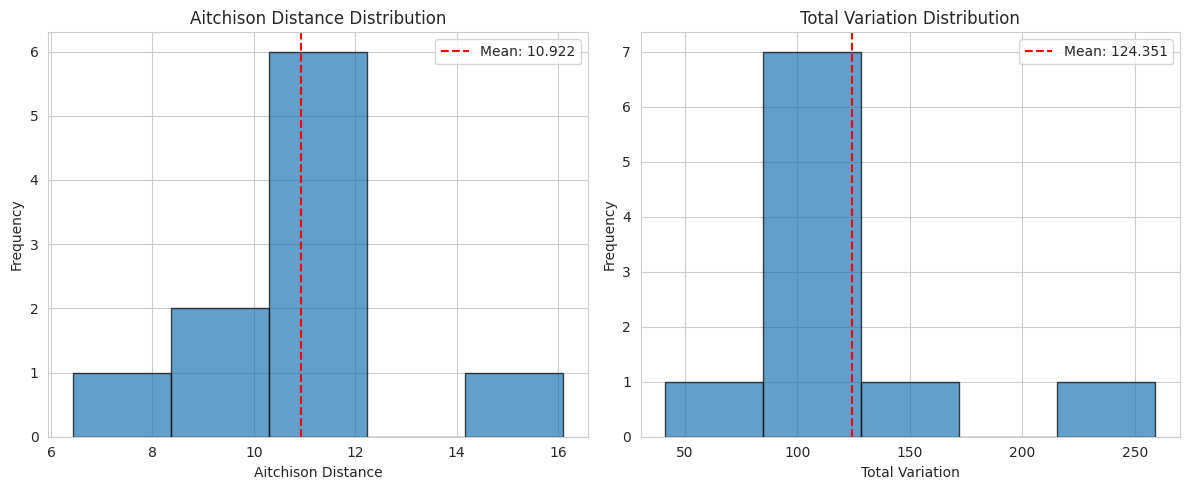


=== 統計サマリー (10試行) ===
Aitchison Distance:
  - 平均: 10.9225
  - 標準偏差: 2.2475
  - 中央値: 10.9725
  - 範囲: [6.4255, 16.0975]

Total Variation:
  - 平均: 124.3513
  - 標準偏差: 51.8979
  - 中央値: 120.3965
  - 範囲: [41.2875, 259.1292]


In [8]:
# より多くの試行で評価結果を可視化
print("=== 可視化用データの生成 ===")
viz_n_trials = 10
viz_result = evaluator.run_period_evaluation(test_period, n_trials=viz_n_trials)

if viz_result["summary_statistics"]["n_successful_trials"] > 0:
    # 評価指標の分布を可視化
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Aitchison距離のヒストグラム
    aitchison_distances = viz_result["summary_statistics"]["aitchison_distances"]
    axes[0].hist(aitchison_distances, bins=5, alpha=0.7, edgecolor="black")
    axes[0].set_title("Aitchison Distance Distribution")
    axes[0].set_xlabel("Aitchison Distance")
    axes[0].set_ylabel("Frequency")
    axes[0].axvline(
        np.mean(aitchison_distances),
        color="red",
        linestyle="--",
        label=f"Mean: {np.mean(aitchison_distances):.3f}",
    )
    axes[0].legend()

    # Total Variationのヒストグラム
    total_variations = viz_result["summary_statistics"]["total_variations"]
    axes[1].hist(total_variations, bins=5, alpha=0.7, edgecolor="black")
    axes[1].set_title("Total Variation Distribution")
    axes[1].set_xlabel("Total Variation")
    axes[1].set_ylabel("Frequency")
    axes[1].axvline(
        np.mean(total_variations),
        color="red",
        linestyle="--",
        label=f"Mean: {np.mean(total_variations):.3f}",
    )
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # 統計サマリー
    print(f"\n=== 統計サマリー ({viz_n_trials}試行) ===")
    print("Aitchison Distance:")
    print(f"  - 平均: {np.mean(aitchison_distances):.4f}")
    print(f"  - 標準偏差: {np.std(aitchison_distances):.4f}")
    print(f"  - 中央値: {np.median(aitchison_distances):.4f}")
    print(
        f"  - 範囲: [{np.min(aitchison_distances):.4f}, {np.max(aitchison_distances):.4f}]"
    )

    print("\nTotal Variation:")
    print(f"  - 平均: {np.mean(total_variations):.4f}")
    print(f"  - 標準偏差: {np.std(total_variations):.4f}")
    print(f"  - 中央値: {np.median(total_variations):.4f}")
    print(f"  - 範囲: [{np.min(total_variations):.4f}, {np.max(total_variations):.4f}]")
else:
    print("成功した試行がないため、可視化をスキップします")

## 7. 全時期での小規模テスト

In [9]:
# 全時期での非常に小規模なテスト
print("=== 全時期での小規模テスト ===")
mini_n_trials = 2

all_results = {}
for period in model_config.time_periods.keys():
    period_name = model_config.time_periods[period]
    print(f"\n時期 {period} ({period_name}) を評価中...")

    result = evaluator.run_period_evaluation(period, n_trials=mini_n_trials)
    all_results[period] = result

    stats = result.get("summary_statistics", {})
    print(f"  - 試行数: {result.get('n_trials', 0)}")
    print(f"  - 成功数: {stats.get('n_successful_trials', 0)}")
    if stats.get("n_successful_trials", 0) > 0:
        print(
            f"  - 平均Aitchison距離: {stats.get('mean_aitchison_distance', 'N/A'):.4f}"
        )
        print(
            f"  - 平均Total Variation: {stats.get('mean_total_variation', 'N/A'):.4f}"
        )

# サマリーテーブルの作成
summary_data = []
for period, result in all_results.items():
    stats = result.get("summary_statistics", {})
    summary_data.append(
        {
            "Period": period,
            "Period_Name": model_config.time_periods[period],
            "N_Trials": result.get("n_trials", 0),
            "N_Success": stats.get("n_successful_trials", 0),
            "Success_Rate": stats.get("success_rate", 0.0),
            "Mean_Aitchison": stats.get("mean_aitchison_distance", np.nan),
            "Mean_TotalVar": stats.get("mean_total_variation", np.nan),
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\n=== 全時期サマリー ===")
print(summary_df.to_string(index=False, float_format="%.4f"))

=== 全時期での小規模テスト ===

時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/2 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  50%|█████     | 1/2 [00:42<00:42, 42.21s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 2/2 [01:24<00:00, 42.17s/it]


  - 試行数: 2
  - 成功数: 2
  - 平均Aitchison距離: 10.8906
  - 平均Total Variation: 119.1632

時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/2 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  50%|█████     | 1/2 [00:42<00:42, 42.86s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 2/2 [01:25<00:00, 42.86s/it]


  - 試行数: 2
  - 成功数: 2
  - 平均Aitchison距離: 10.0473
  - 平均Total Variation: 102.1975

時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/2 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  50%|█████     | 1/2 [00:42<00:42, 42.23s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 2/2 [01:24<00:00, 42.23s/it]


  - 試行数: 2
  - 成功数: 2
  - 平均Aitchison距離: 3.9059
  - 平均Total Variation: 16.9528

時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/2 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  50%|█████     | 1/2 [00:42<00:42, 42.24s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 2/2 [01:25<00:00, 42.56s/it]


  - 試行数: 2
  - 成功数: 2
  - 平均Aitchison距離: 10.7389
  - 平均Total Variation: 115.4506

時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/2 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  50%|█████     | 1/2 [00:42<00:42, 42.21s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 2/2 [01:24<00:00, 42.23s/it]

  - 試行数: 2
  - 成功数: 2
  - 平均Aitchison距離: 8.9009
  - 平均Total Variation: 87.8662

=== 全時期サマリー ===
 Period Period_Name  N_Trials  N_Success  Success_Rate  Mean_Aitchison  Mean_TotalVar
      0      早期・早々期         2          2        1.0000         10.8906       119.1632
      1          前期         2          2        1.0000         10.0473       102.1975
      2          中期         2          2        1.0000          3.9059        16.9528
      3          後期         2          2        1.0000         10.7389       115.4506
      4          晩期         2          2        1.0000          8.9009        87.8662


## 8. パフォーマンス測定

In [10]:
import time

# 単一試行の実行時間測定
if len(available_sites) > 0:
    print("=== パフォーマンス測定 ===")

    # 5回の試行で平均実行時間を測定
    execution_times = []
    for i in range(3):
        start_time = time.time()
        result = evaluator.run_single_trial(test_period, available_sites[0])
        end_time = time.time()
        execution_times.append(end_time - start_time)

    avg_time = np.mean(execution_times)
    print(f"単一試行の平均実行時間: {avg_time:.2f}秒")
    print(f"100試行の推定実行時間: {avg_time * 100 / 60:.1f}分")
    print(f"全時期100試行の推定実行時間: {avg_time * 100 * 5 / 60:.1f}分")
else:
    print("パフォーマンス測定をスキップ（テスト可能な遺跡なし）")

=== パフォーマンス測定 ===
creating weights matrix...
calculating distance_W...
updating weights matrix...
creating weights matrix...
calculating distance_W...
updating weights matrix...
creating weights matrix...
calculating distance_W...
updating weights matrix...
単一試行の平均実行時間: 45.45秒
100試行の推定実行時間: 75.8分
全時期100試行の推定実行時間: 378.8分


## 9. エラーハンドリングのテスト

In [11]:
# 存在しない遺跡でのテスト
print("=== エラーハンドリングのテスト ===")

# 存在しない遺跡ID
fake_site_id = 99999
error_result = evaluator.run_single_trial(test_period, fake_site_id)

print(f"存在しない遺跡{fake_site_id}でのテスト:")
print(f"  - 成功: {error_result['success']}")
if not error_result["success"]:
    print(f"  - エラー: {error_result['error']}")

# 異常な構成比のテスト
print("\n=== 異常な構成比での評価指標テスト ===")
abnormal_x = np.array([1.0, 0.0, 0.0, 0.0, 0.0])  # 極端な分布
abnormal_y = np.array([0.0, 0.0, 0.0, 0.0, 1.0])  # 逆の極端な分布

try:
    abnormal_aitchison = metrics.aitchison_distance(abnormal_x, abnormal_y)
    abnormal_total_var = metrics.total_variation(abnormal_x, abnormal_y)
    print("極端な分布間の距離:")
    print(f"  - Aitchison Distance: {abnormal_aitchison:.4f}")
    print(f"  - Total Variation: {abnormal_total_var:.4f}")
except Exception as e:
    print(f"エラー: {e}")

print("\n=== デバッグ完了 ===")
print("システムは正常に動作しているようです。")

=== エラーハンドリングのテスト ===
creating weights matrix...
calculating distance_W...
updating weights matrix...
エラー: 遺跡99999, 時期0の試行でエラー: 遺跡ID 99999 が見つかりません
存在しない遺跡99999でのテスト:
  - 成功: False
  - エラー: 遺跡ID 99999 が見つかりません

=== 異常な構成比での評価指標テスト ===
極端な分布間の距離:
  - Aitchison Distance: 19.5381
  - Total Variation: 381.7367

=== デバッグ完了 ===
システムは正常に動作しているようです。
